In [1]:
##########################################################
# Relative Imports
##########################################################
import sys
from os.path import isfile
from os.path import join


def find_pkg(name: str, depth: int):
    if depth <= 0:
        ret = None
    else:
        d = [".."] * depth
        path_parts = d + [name, "__init__.py"]

        if isfile(join(*path_parts)):
            ret = d
        else:
            ret = find_pkg(name, depth - 1)
    return ret


def find_and_ins_syspath(name: str, depth: int):
    path_parts = find_pkg(name, depth)
    if path_parts is None:
        raise RuntimeError("Could not find {}. Try increasing depth.".format(name))
    path = join(*path_parts)
    if path not in sys.path:
        sys.path.insert(0, path)


try:
    import caldera
except ImportError:
    find_and_ins_syspath("caldera", 3)

# Caldera

In [2]:
import caldera

## Data tour

### GraphData

The primary data object used by caldera. We can generate random objects by using `GraphData.random` for testing and demo purposes...

In [3]:
from caldera.data import GraphData

data = GraphData.random(n_feat=5, e_feat=4, g_feat=3)
data

<GraphData size(n,e,g)=torch.Size([2, 8, 1]) features(n,e,g)=torch.Size([5, 4, 3])>

`GraphData` instances contain node tensor (`data.x`), edge tensor (`data.e`) and global tensor (`data.g`). They also keep graph topology
via and edge list, `data.edges`, which indicates edges by node indices. Note that this mean graphs are MultiGraphs (multiple edges between same nodes allowed)

#### node features

Each node gets a tensor. These tensors are stack into `data.x`

In [4]:
print('We have {} nodes'.format(data.x.shape[0]))
print('Each node has a feature tensor of shape {}'.format(data.x.shape[1]))
print("Overall shape: {}".format(data.x.shape))
data.x

We have 2 nodes
Each node has a feature tensor of shape 5
Overall shape: torch.Size([2, 5])


tensor([[ 0.2496, -0.3646,  0.3904, -0.4723, -0.5130],
        [-1.4683,  1.2624, -0.1099, -0.1572, -0.9023]])

#### edge features

Each edge gets a tensor. These tensors are stack into `data.e`

In [5]:
print('We have {} edge(s)'.format(data.e.shape[0]))
print('Each edge has a feature tensor of shape {}'.format(data.e.shape[1]))
print("Overall shape: {}".format(data.e.shape))
data.x

We have 8 edge(s)
Each edge has a feature tensor of shape 4
Overall shape: torch.Size([8, 4])


tensor([[ 0.2496, -0.3646,  0.3904, -0.4723, -0.5130],
        [-1.4683,  1.2624, -0.1099, -0.1572, -0.9023]])

#### global features

Each graph gets a single global tensor. These tensors are stack into `data.g`. 

We may use this, for example, to label each graph with a category.

In [6]:
print('We have a single global tensor of shape {}'.format(data.g.shape))
data.g

We have a single global tensor of shape torch.Size([1, 3])


tensor([[-0.1705, -1.5258, -0.8309]])

#### edges

Graph topology is store in the `data.edges` attribute. This indicates which nodes (by index) are connected.

In [7]:
data.edges

tensor([[1, 0, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 0, 0, 0, 0, 1]])

### Conversion

We can convert `GraphData` instances to and from networkx instances (graphs).

<GraphData size(n,e,g)=torch.Size([11, 3, 1]) features(n,e,g)=torch.Size([5, 4, 3])>
tensor([[ 4,  7,  0],
        [ 3,  6, 10]])


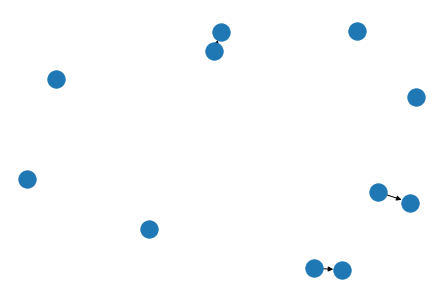

In [8]:
import networkx as nx
%matplotlib inline

data = GraphData.random(5, 4, 3)

# convert to a networkx object
graph = data.to_networkx()

# draw
nx.draw(graph)

# convert back to GraphData object
from_nx = GraphData.from_networkx(graph)
print(from_nx)
print(data.edges)

## GraphBatches

We can represent multiple graphs using a GraphBatch.

In [9]:
from caldera.data import GraphBatch

data_list = [GraphData.random(5, 4, 3), GraphData.random(5, 4, 3)]
batch = GraphBatch.from_data_list(data_list)


# Common Questions

**How does caldera handle arbitrary sized graphs? I thought neural networks had to have defined input-output dimensions.**

It does! However, Pytorch can handle arbitrary `batch` sizes. Lets check this out on a simple `torch.nn.Linear` module.

**Does caldera do anything really special?**

No not really. Just as PyTorch does not do anything really that special. They are both frameworks to generate and train neural networks. In both, the implementation and API are intimately linked to the construction of neural networks. Caldera has specialized classes and methods to handle graph-like data as torch.Tensor objects and specialized NN construction methods.

In [10]:
import torch

# we create some random data 
# we have a batch size of 3
# and we have 10 features
x = torch.randn(3, 10)
lin = torch.nn.Linear(10, 2)
lin(x)

tensor([[-0.6517,  0.8182],
        [ 0.9411,  0.2952],
        [-0.3964, -0.5660]], grad_fn=<AddmmBackward>)

In [11]:
# notice how this does not work
# if there is a size mismatch
x = torch.randn(3, 10)
lin = torch.nn.Linear(11, 2)
lin(x)

RuntimeError: size mismatch, m1: [3 x 10], m2: [11 x 2] at /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/TH/generic/THTensorMath.cpp:41

Now, knowing that Pytorch handles arbitrary dimensions (in the first dimension), we can batch together a graphs along their `node`, `edge` or `global` features.

For example, lets say we have a graph with 2 nodes, 0 edges and a graph with 5 nodes, and 2 edges

In [13]:
from caldera.data import GraphData


nodes = torch.tensor([
    [0, 0, 0],  # node 0
    [1, 0, 0],  # node 1
    [0, 1, 0],  # node 2
    [0, 1, 0]   # node 3
])
edges = torch.tensor([
    [0],  # edge 0
    [0],  # edge 1
    [1]   # edge 2
])


# edges 0-->1, 2-->3, 3-->0
edges = torch.tensor([
    
    [0, 2, 3],
    [1, 3, 0]
#    ^  ^  ^
#    0  1  2
])

assert edges.shape[0] = edges.shape[0]

SyntaxError: invalid syntax (<ipython-input-13-91b27513e360>, line 26)

Now how do we batch graphs together? Lets just concatenate nodes, edges, and globals...

We will keep track of which node belongs to which graph using `torch.LongTensor` (`node_idx`)
and track which edge belongs to which graph using `edge_idx`. 

# torch modules

Here we discuss how to inherit torch modules.


## Basic Graph Encoder

### Blocks

Here we discuss the basic building blocks for all of caldera's neural networks. The EdgeBlock, NodeBlock, and GlobalBlock. Within each block, we can have *arbitrary* modules. Really, these can be anything we want. 

#### Dense 

This is your basic multi-layer perceptron (a fancy term for a dense neural network). To begin, lets go over how pytorch modules and forward propogation works

In [14]:
from torch import nn

# initialize our toy network
lin1 = nn.Linear(10, 5)
act1 = nn.ReLU()
lin2 = nn.Linear(5, 2)
act2 = nn.ReLU()
lin3 = nn.Linear(2, 5)
act3 = nn.ReLU()
lin4 = nn.Linear(5, 1)
act4 = nn.Sigmoid()

# some fake data
x = torch.randn(20, 10) # note that the second dimension MUST be 10 since lin1 input dim is 10
                        # 20 is the batch size and can be any number
    
# forward propogation
print(x.shape)
x = lin1(x)
x = act1(x)
x = lin2(x)
x = act2(x)
x = lin3(x)
x = act3(x)
x = lin4(x)
x = act4(x)
print(x.shape)

torch.Size([20, 10])
torch.Size([20, 1])


We could do essentially the same thing using pytorch's standard Sequential model. The `Sequential` model takes a list of other modules and connects them together sequentially.

In [15]:
layers = nn.Sequential(
    nn.Linear(10, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.ReLU(),
)
x = torch.randn(20, 10)
layers(x)

tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.3305],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000]], grad_fn=<ReluBackward0>)

This **module composition** is very convinient as it keeps all of our code neat and tidy. Additionally, we have all of our parameters in one place. We can go one step further and create a whole new module to keep all of this.

In [16]:
class Dense(torch.nn.Module):
    
    def __init__(self, s1, s2):
        super().__init__() # MUST be called to implement torch.nn.Module
        self.layers = nn.Sequential(
            nn.Linear(s1, s2),
            nn.ReLU(),
            nn.Linear(s2, 1),
            nn.ReLU(),
        )
        
    # the built in method we need to implement
    def forward(self, x):
        return self.layers(x)
    
Dense(10, 5)

Dense(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=1, bias=True)
    (3): ReLU()
  )
)

In [17]:
Dense(10, 5)(x)

tensor([[0.2983],
        [0.0263],
        [0.2283],
        [0.0000],
        [0.0000],
        [0.3209],
        [0.0000],
        [0.0000],
        [0.2197],
        [0.0000],
        [0.0000],
        [0.2245],
        [0.0006],
        [0.1633],
        [0.0207],
        [0.0477],
        [0.0945],
        [0.3365],
        [0.1346],
        [0.3091]], grad_fn=<ReluBackward0>)

### Flex block and flexible dimensions

One of the most fustrating aspects of complex neural networks is getting the **size** correct. This is particularly troublesome with some of the neural networks Caldera creates.

To overcome this, Caldera has a small module called a `FlexBlock` that automatically infers dimensions.

We can convert almost any pytorch module into a flexible module by calling `Flex(<ModuleType>)`. Lets start by making a flexible Linear module.

In [18]:
from caldera.blocks import Flex
from rich.panel import Panel
from rich import print
from rich.console import Console
FlexLinear = Flex(nn.Linear)
flex_lin1 =  FlexLinear(..., 10)
lin1 = nn.Linear(5, 10)

print(Panel(str(lin1), title='standard version'))

print(Panel(str(flex_lin1), title='flexible version (unresolved)', style='red'))

Notice the word `unresolved_module` in the FlexBlock. This means we *do not yet know the dimenions* of this module. To *resolve* the module, all we have to do is pass in some data. This will resolve the dimensions at the position indicated by the `...` argument.

The `...` is just syntatic sugar to define a `FlexDim` instance. FlexDim will resolve the indicated argument position `pos` using the input data dimension `dim`. By default, when `...` is provided, it will default to its own arg position and dim=1. In most cases, just using `...` at the position you want to be flexible will suffice. Use `FlexDim` if there are multiple flexible dimensions and multiple flexible positions.

In [22]:
flex_lin1(torch.randn(10, 5))
print(Panel(str(flex_lin1), title='flexible version (resolved)', style='green'))

Notice that we now have a Linear layer with expected shape 5. This means the module is resolved and can be used as normal. The flex block if powerful if used in module compositions. For example, in sequential compositions...

In [23]:
type(...)

ellipsis

In [24]:
layer = nn.Sequential(
    Flex(nn.Linear)(..., 10),
    nn.ReLU(),
    Flex(nn.Linear)(..., 4),
    nn.Sigmoid()
)

## Message passing (how we pass information throughout a graph neural network)

How to we pass data in the graph? We will use graph neighbors to pass information to the current node.

### Message passing and representation learning

In [24]:
nn.ReLU()

NameError: name 'nn' is not defined